In [22]:
import sqlite3
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

O Banco de Dados em formato sqlite possuí a tabela SO_QUESTION que contém as colunas: 
<img src="imagens/BD.png" alt="drawing" width="400"/>

As informações de cada tabela são:

**SO_QUESTION** - *Stack Overflow Questions*:
- ID: identificador da questão na base de dados
- SO_ID: indentificador da questão no site do stackoverflow
- OWNER_ID: ??
- CREATION_DATE: data de criação da questão.

**SO_TAG** - *Stack Overflow Tag*:
- ID: indetificador da tag na base de dados
- SO_ID: indetificador da tag no site do stackoverflow

**SO_QUESTION_TAG** - Tabela de relacionamento NxN de questões e tags
- ID: identificador do relacionamento
- Q_ID: identificador da questão na base de dados
- TAG_ID: identificador da tag na base de dados


# Tratamento dos Dados, formato nó e link.

Obter as informações do Nó. O tamanho do Nó representa quantas perguntas em que ele esta presente como tag.

INSERT INTO public."Node2"("NAME", "SIZE", "GROUP")	
	SELECT TAG.so_id, COUNT(R.ID), NULL
	from SO_QUESTION_TAG R
	inner join SO_TAG TAG
	on TAG.ID = R.tag_id
	GROUP BY TAG.so_id; 

insert into public."LINK"("SOURCE", "TARGET", "SIZE")
select tag_source.so_id, tag_target.so_id, count(*)
from public."LINK_ID" l_id
inner join so_tag tag_source
on l_id.id_source = tag_source.id
inner join so_tag tag_target
on l_id.id_target = tag_target.id
group by tag_source.so_id, tag_target.so_id;


INSERT INTO public."LINK_ID"("id_source", "id_target")

select 
	tag1.tag_id, tag2.tag_id
  from 
  	so_question_tag tag1
	inner join so_question_tag tag2
	on tag1.q_id = tag2.q_id
	and tag1.tag_id < tag2.tag_id;

In [2]:
conn = sqlite3.connect('dados/grafo.db', timeout=10)
cursor_grafo = conn.cursor()

cursor_grafo.execute('''DROP TABLE NODE''');
cursor_grafo.execute('''CREATE TABLE NODE
             ([ID] INTEGER PRIMARY KEY,[NAME] text, [SIZE] integer)''')

cursor_grafo.execute('''DROP TABLE LINK''');
cursor_grafo.execute('''CREATE TABLE LINK
             ([ID] INTEGER PRIMARY KEY,[SOURCE] text, [TARGET] text, [SIZE] integer)''')

conn.commit()

In [3]:
# Insere Nós e Tamanho do nó.
# Percorrer tabela de Tags E fazer count na tabela de relacionamento
conn = sqlite3.connect('dados/grafo.db', timeout=10)
cursor_grafo = conn.cursor()

conn = sqlite3.connect('dados/tags_database.db', timeout=10)
cursor_so = conn.cursor()

# Select das tags
query = """SELECT * from SO_TAG"""
cursor_so.execute(query)
rows = cursor_so.fetchall()
total = len(rows)
print("Total rows are:  ", total)

import time

start_time_total = time.time()


max_id = 0;
i = 0
links_processados = 0;
for row in rows:
    
    tag_id = row[0]
    tag_so_id = row[1]
    #print("Id: ", tag_id)
    #print("SO_ID: ", tag_so_id) 
    query = """SELECT COUNT(ID) from SO_QUESTION_TAG WHERE TAG_ID = """ + str(tag_id);
    cursor_so.execute(query)    
    size = cursor_so.fetchone()[0];
    #query = """DELETE from SO_QUESTION_TAG WHERE TAG_ID = """ + str(tag_id);
    #cursor_so.execute(query)
    #size = cursor_so.rowcount;
    #print("Size: ", size)     
    links_processados = links_processados + size;
    if size > 10000:
        sql = ''' INSERT INTO NODE(ID,NAME,SIZE) VALUES(?,?,?) '''
        node = (tag_id, tag_so_id, size)
        cursor_grafo.execute(sql, node)
    
    if(i % 100 == 0):        
        start_time_lote = time.time()
        print("Progresso: ", i)
        print("--- %s seconds total ---" % (time.time() - start_time_total))
        print("--- %s seconds lote ---" % (time.time() - start_time_lote))
        if(i > 18000):
            break;
    i = i + 1
    #if i == 10:
    #    break;
cursor_grafo.close()
cursor_so.close()

Total rows are:   46431
Progresso:  0
--- 27.044936895370483 seconds total ---
--- 0.0014488697052001953 seconds lote ---
Progresso:  100
--- 155.43002939224243 seconds total ---
--- 0.00010061264038085938 seconds lote ---
Progresso:  200
--- 287.7208411693573 seconds total ---
--- 0.00011563301086425781 seconds lote ---
Progresso:  300
--- 442.2576913833618 seconds total ---
--- 0.00010514259338378906 seconds lote ---
Progresso:  400
--- 606.0511319637299 seconds total ---
--- 0.00016880035400390625 seconds lote ---
Progresso:  500
--- 772.8132600784302 seconds total ---
--- 0.00037479400634765625 seconds lote ---
Progresso:  600
--- 914.8979318141937 seconds total ---
--- 0.00040340423583984375 seconds lote ---
Progresso:  700
--- 1085.354008436203 seconds total ---
--- 0.00019311904907226562 seconds lote ---
Progresso:  800
--- 1227.9529421329498 seconds total ---
--- 8.225440979003906e-05 seconds lote ---
Progresso:  900
--- 1369.930914402008 seconds total ---
--- 0.000392436981201

KeyboardInterrupt: 

In [12]:
cursor_grafo.close()
cursor_so.close()

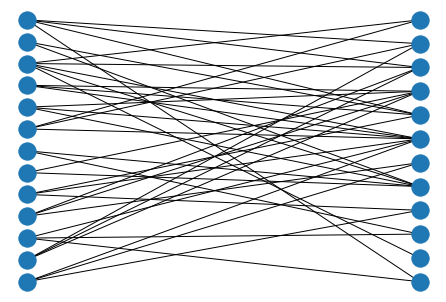

In [17]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

classInput = '123\n14567\n128\n589\n1ab\n259b\n58c\n78\n169\n7a\n27\n13c\n178'

lines = classInput.split('\n')

classNet = nx.Graph()
i = 1
for line in lines:
  node = 's'+str(i)
  classNet.add_node(node, bipartite=0)
  for j in range(len(line)):
    neigh = 'h' + line[j]
    classNet.add_edge(node, neigh)
  i += 1
people = nx.bipartite.sets(classNet)[0]
hobbies = nx.bipartite.sets(classNet)[1]
pos = nx.bipartite_layout(classNet, people)
nx.draw(classNet, pos)

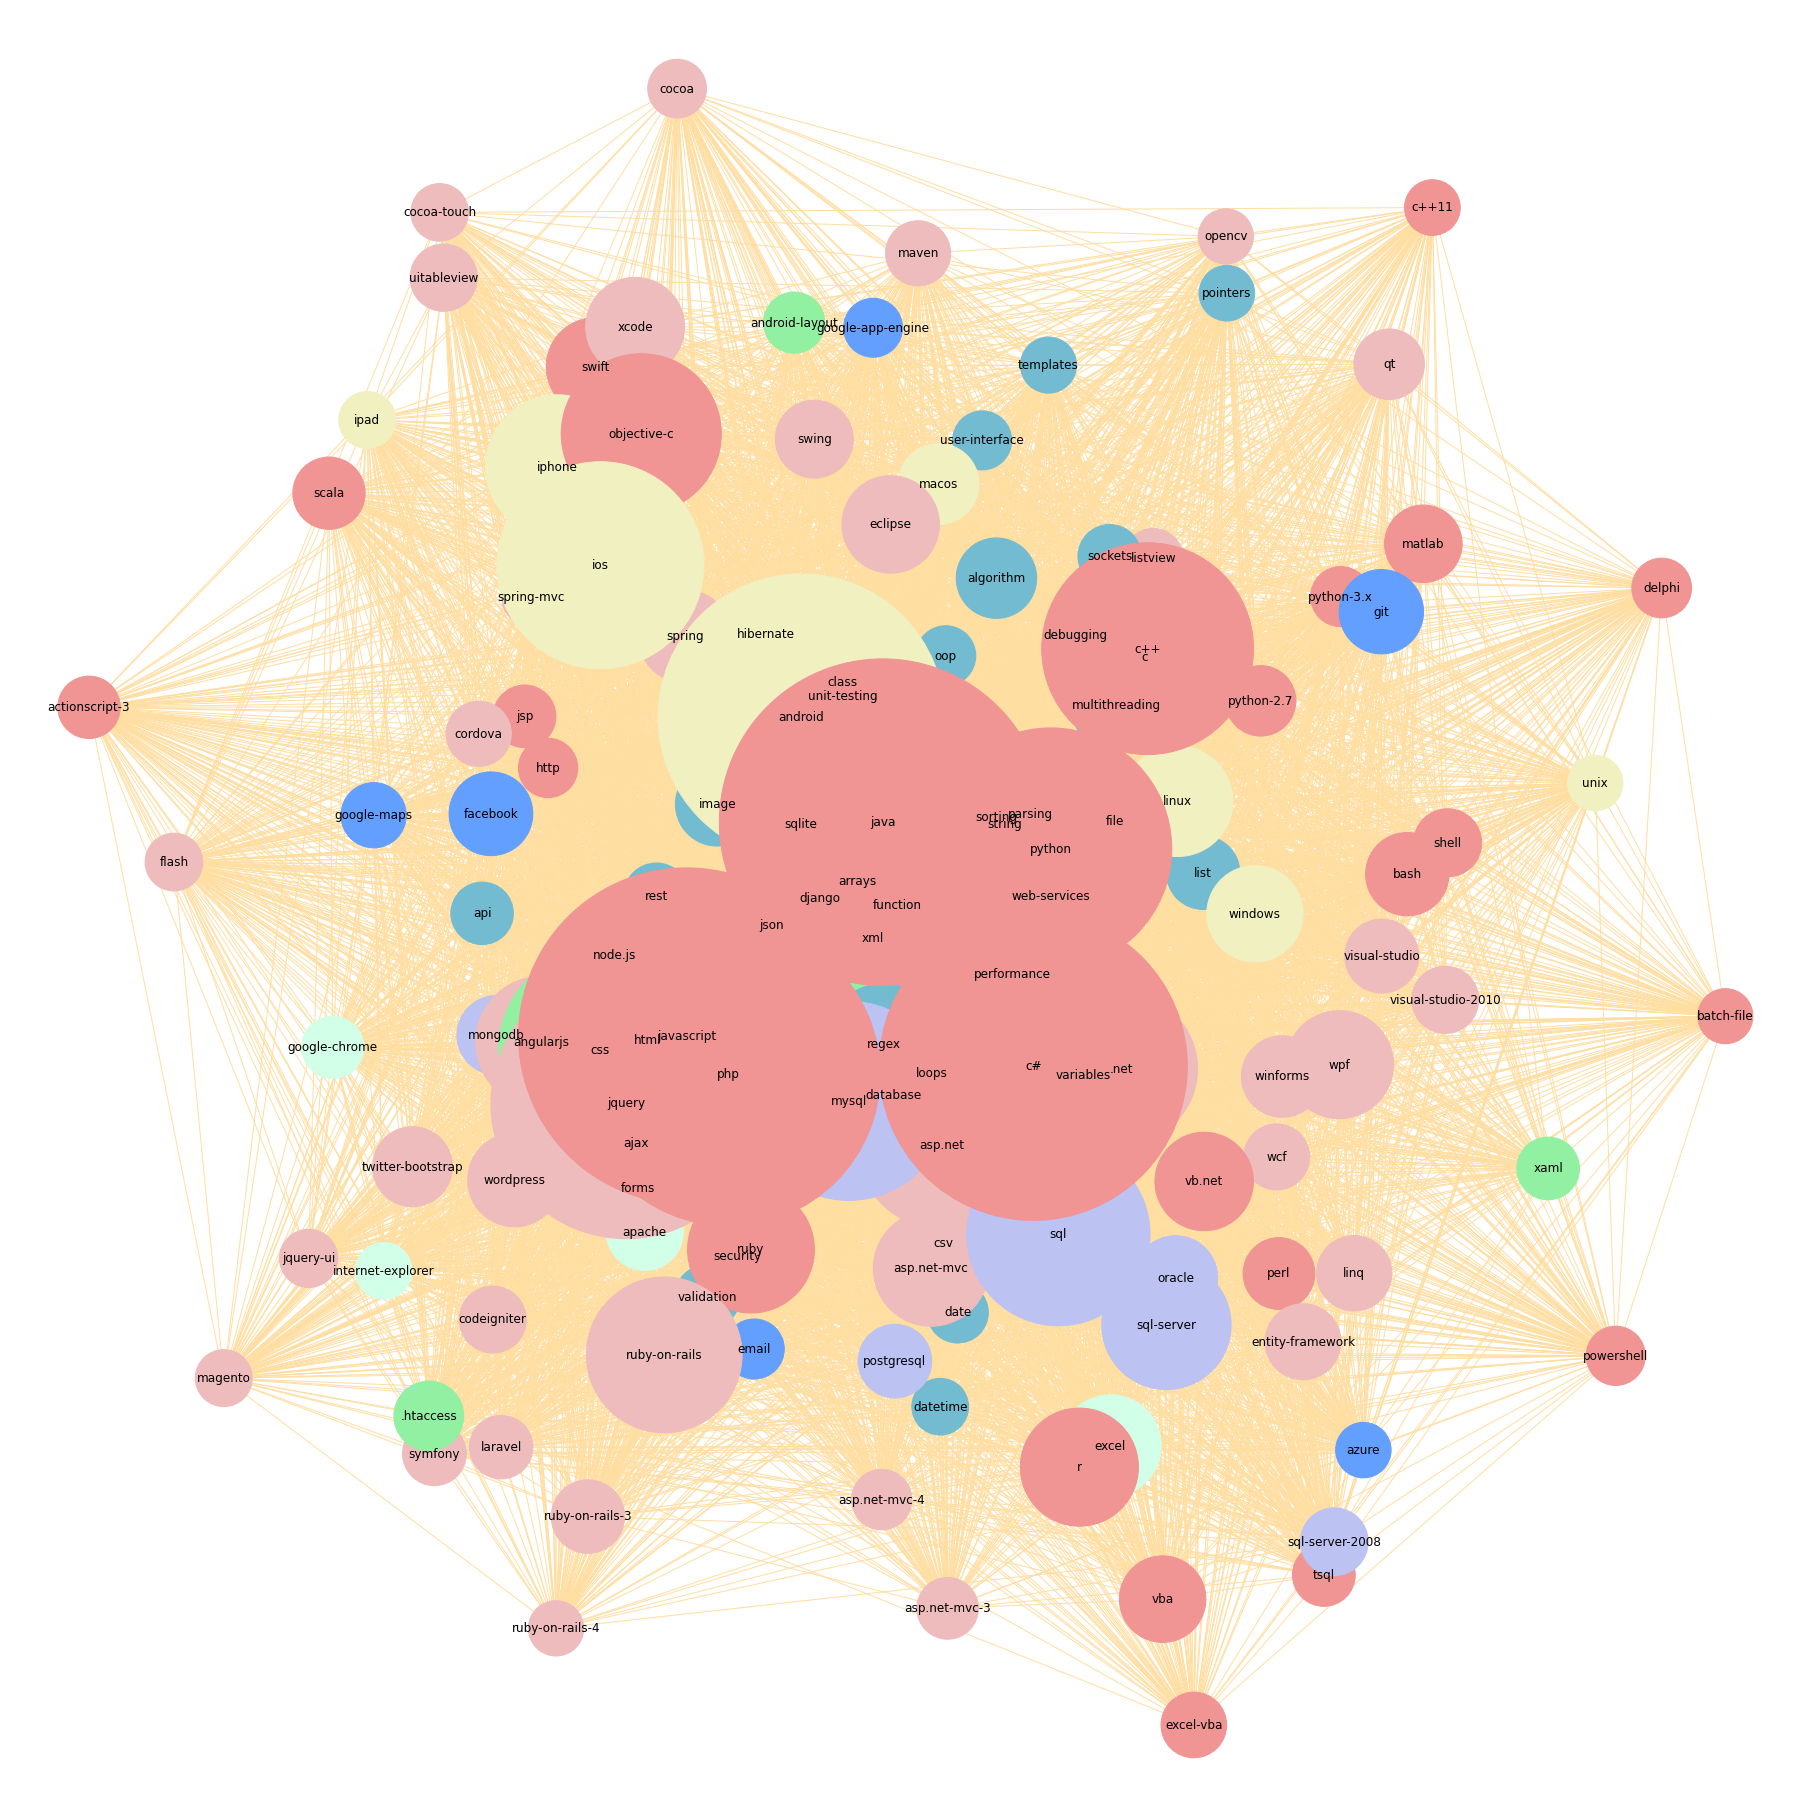

In [35]:
conn = sqlite3.connect('dados/nodes_links.db', timeout=10)
cursor_so = conn.cursor()

G = nx.Graph(day="Stackoverflow")

# Select das tags
#query = """SELECT * from LINK"""
#cursor_so.execute(query)
cursor_so.execute('SELECT * from NODE') 
for row in cursor_so:
    G.add_node(row[1], nodesize=row[2], group=row[3])
    
cursor_so.execute('SELECT * from LINK') 
for row in cursor_so:
    if(row[1] != 'session' and row[2] != 'session'):
        G.add_weighted_edges_from([(row[1], row[2], row[3])])

sizes = [G.nodes[node]['nodesize']/10 for node in G]

color_map = {1:'#f09494', 2:'#eebcbc', 3:'#72bbd0', 4:'#91f0a1', 5:'#629fff', 6:'#bcc2f2',  
             7:'#eebcbc', 8:'#f1f0c0', 9:'#d2ffe7'} 
colors = [color_map[G.nodes[node]['group']] for node in G]



plt.figure(figsize=(25,25));
options = {
    'edge_color': '#FFDEA2',
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
}
nx.draw(G, node_size=sizes, pos=nx.spring_layout(G, k=0.25, iterations=50), **options, node_color=colors);
plt.show();

#rows = cursor_so.fetchall()
#total = len(rows)
#print("Total rows are:  ", total)

# Select das tags
#query = """SELECT * from NODE"""
#cursor_so.execute(query)
#rows = cursor_so.fetchall()
#total = len(rows)
#print("Total rows are:  ", total)

In [19]:
G = nx.Graph(day="Stackoverflow")

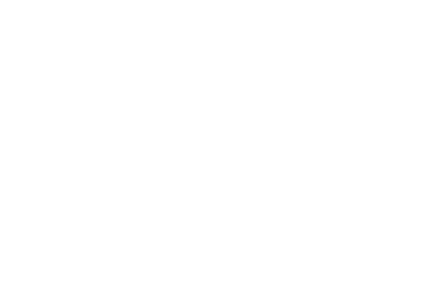

In [20]:
#NODE(ID,NAME,SIZE)
query = """SELECT * from NODE"""
cursor_grafo.execute(query)
rows = cursor_so.fetchall()

before = None;
for row in rows:    
    G.add_node(row[1], nodesize=row[2])
    if(before != None):
        G.add_edge(row[1], before)
    before = row[1];


    
    
nx.draw(G)
#ax = plt.gca()
#print(ax)
#print(ax.collections)
#ax.collections[0].set_edgecolor("#555555") 
#plt.show()